# Housing Price Prediction - Advanced Models
## CPSC 4310 - Milestone 3

**Student:** Chloe Lee  
**Date:** February 2025  
**Goal:** Build advanced models (Random Forest & XGBoost) to improve predictions

---

## Objectives:
1. Load baseline model results for comparison
2. Build Random Forest model
3. Build XGBoost model
4. Compare all three models
5. Analyze feature importance
6. Generate final predictions for dashboard

---
# Part 1: Setup and Data Loading

In [1]:
# Install if needed (uncomment and run once):
# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost
import sys
!{sys.executable} -m pip install matplotlib seaborn scikit-learn xgboost
print("Run the line above if you get import errors!")

Run the line above if you get import errors!


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [3]:
# Load data
print("Loading data...")
df = pd.read_csv('output/housing_data_with_features.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"✓ Data loaded: {len(df)} rows, {len(df.columns)} columns")

Loading data...
✓ Data loaded: 1260 rows, 23 columns


In [4]:
# Define features and target (same as baseline)
feature_cols = [
    'Index_Lag1', 'Index_Lag3', 'Index_Lag12',
    'Mortgage_1Y', 'Mortgage_3Y', 'Mortgage_5Y', 'Prime_Rate',
    'Index_YoY_Change', 'Mortgage_5Y_Change',
    'Index_MA3', 'Index_MA12',
    'Month', 'Quarter',
    'Price_Above_MA3', 'MA3_MA12_Diff'
]

target_col = 'Index_MoM_Change'

print(f"Features: {len(feature_cols)}")
print(f"Target: {target_col}")

Features: 15
Target: Index_MoM_Change


In [5]:
# Prepare data (same as baseline)
print("Preparing data...")

df_clean = df[feature_cols + [target_col, 'Date', 'City', 'Year']].dropna()

SPLIT_YEAR = 2024
train_mask = df_clean['Year'] < SPLIT_YEAR
test_mask = df_clean['Year'] >= SPLIT_YEAR

X_train = df_clean.loc[train_mask, feature_cols]
y_train = df_clean.loc[train_mask, target_col]
X_test = df_clean.loc[test_mask, feature_cols]
y_test = df_clean.loc[test_mask, target_col]

print(f"Train: {len(X_train)} samples")
print(f"Test: {len(X_test)} samples")

Preparing data...
Train: 1080 samples
Test: 120 samples


---
# Part 2: Load Baseline Results

Load the baseline model results to compare.

In [6]:
# Try to load baseline results (if available)
try:
    baseline_results = pd.read_csv('baseline_model_performance.csv')
    print("Baseline Model Performance:")
    print("="*60)
    display(baseline_results)
    
    baseline_test_r2 = baseline_results['Test_R2'].values[0]
    baseline_test_mape = baseline_results['Test_MAPE'].values[0]
    
    print(f"\n✓ Baseline to beat:")
    print(f"  R² = {baseline_test_r2:.4f}")
    print(f"  MAPE = {baseline_test_mape:.2f}%")
    
except FileNotFoundError:
    print("⚠ Baseline results not found. We'll still build advanced models!")
    baseline_test_r2 = None
    baseline_test_mape = None

Baseline Model Performance:


,Model,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_R2,Test_R2,Train_MAPE,Test_MAPE
0,Linear Regression,0.368745,0.251639,0.249574,0.206922,0.923143,0.924699,47.26442,51.913533



✓ Baseline to beat:
  R² = 0.9247
  MAPE = 51.91%


---
# Part 3: Random Forest Model

**Why Random Forest?**
- Handles non-linear relationships (Linear Regression can't)
- Less prone to overfitting than single decision tree
- Provides feature importance
- No need to scale features

In [7]:
print("="*80)
print("TRAINING RANDOM FOREST")
print("="*80)

# Initialize Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=15,          # Maximum depth of each tree
    min_samples_split=5,   # Minimum samples to split a node
    min_samples_leaf=2,    # Minimum samples in a leaf
    random_state=42,       # For reproducibility
    n_jobs=-1,             # Use all CPU cores
    verbose=1              # Show progress
)

print("\nModel parameters:")
print(f"  Trees: {rf_model.n_estimators}")
print(f"  Max depth: {rf_model.max_depth}")
print(f"  Min samples split: {rf_model.min_samples_split}")

print("\nTraining...")
rf_model.fit(X_train, y_train)
print("✓ Training complete!")

TRAINING RANDOM FOREST

Model parameters:
  Trees: 100
  Max depth: 15
  Min samples split: 5

Training...
✓ Training complete!


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [8]:
# Make predictions
print("Making predictions...")
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)
print("✓ Predictions generated")

Making predictions...
✓ Predictions generated


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [9]:
# Evaluate Random Forest
def calculate_metrics(y_true, y_pred, model_name=""):
    """Calculate all metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    print(f"{model_name} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

print("="*60)
print("RANDOM FOREST PERFORMANCE")
print("="*60)

rf_train_metrics = calculate_metrics(y_train, rf_train_pred, "RF Training")
print()
rf_test_metrics = calculate_metrics(y_test, rf_test_pred, "RF Test")

# Compare with baseline
if baseline_test_r2 is not None:
    print("\n" + "="*60)
    print("COMPARISON WITH BASELINE")
    print("="*60)
    r2_improvement = ((rf_test_metrics['R2'] - baseline_test_r2) / baseline_test_r2) * 100
    mape_improvement = ((baseline_test_mape - rf_test_metrics['MAPE']) / baseline_test_mape) * 100
    
    print(f"R² improvement: {r2_improvement:+.1f}%")
    print(f"MAPE improvement: {mape_improvement:+.1f}%")
    
    if rf_test_metrics['R2'] > baseline_test_r2:
        print("\n✓ Random Forest BEATS baseline!")
    else:
        print("\n⚠ Random Forest did not beat baseline")

RANDOM FOREST PERFORMANCE
RF Training Metrics:
  RMSE: 0.1899
  MAE:  0.1248
  R²:   0.9796
  MAPE: 27.24%

RF Test Metrics:
  RMSE: 0.2816
  MAE:  0.2228
  R²:   0.9057
  MAPE: 89.17%

COMPARISON WITH BASELINE
R² improvement: -2.1%
MAPE improvement: -71.8%

⚠ Random Forest did not beat baseline


---
# Part 4: XGBoost Model

**Why XGBoost?**
- Usually best performance for tabular data
- Handles complex patterns
- Built-in regularization prevents overfitting
- Very fast training

In [10]:
print("="*80)
print("TRAINING XGBOOST")
print("="*80)

# Initialize XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,       # Number of boosting rounds
    max_depth=6,            # Maximum depth of trees
    learning_rate=0.1,      # Step size for updates
    subsample=0.8,          # Fraction of samples for each tree
    colsample_bytree=0.8,   # Fraction of features for each tree
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

print("\nModel parameters:")
print(f"  Estimators: {xgb_model.n_estimators}")
print(f"  Max depth: {xgb_model.max_depth}")
print(f"  Learning rate: {xgb_model.learning_rate}")

print("\nTraining...")
xgb_model.fit(X_train, y_train)
print("✓ Training complete!")

TRAINING XGBOOST

Model parameters:
  Estimators: 100
  Max depth: 6
  Learning rate: 0.1

Training...
✓ Training complete!


In [11]:
# Make predictions
print("Making predictions...")
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)
print("✓ Predictions generated")

Making predictions...
✓ Predictions generated


In [12]:
# Evaluate XGBoost
print("="*60)
print("XGBOOST PERFORMANCE")
print("="*60)

xgb_train_metrics = calculate_metrics(y_train, xgb_train_pred, "XGB Training")
print()
xgb_test_metrics = calculate_metrics(y_test, xgb_test_pred, "XGB Test")

# Compare with baseline
if baseline_test_r2 is not None:
    print("\n" + "="*60)
    print("COMPARISON WITH BASELINE")
    print("="*60)
    r2_improvement = ((xgb_test_metrics['R2'] - baseline_test_r2) / baseline_test_r2) * 100
    mape_improvement = ((baseline_test_mape - xgb_test_metrics['MAPE']) / baseline_test_mape) * 100
    
    print(f"R² improvement: {r2_improvement:+.1f}%")
    print(f"MAPE improvement: {mape_improvement:+.1f}%")
    
    if xgb_test_metrics['R2'] > baseline_test_r2:
        print("\n✓ XGBoost BEATS baseline!")
    else:
        print("\n⚠ XGBoost did not beat baseline")

XGBOOST PERFORMANCE
XGB Training Metrics:
  RMSE: 0.1174
  MAE:  0.0897
  R²:   0.9922
  MAPE: 24.25%

XGB Test Metrics:
  RMSE: 0.2777
  MAE:  0.2163
  R²:   0.9083
  MAPE: 80.75%

COMPARISON WITH BASELINE
R² improvement: -1.8%
MAPE improvement: -55.5%

⚠ XGBoost did not beat baseline


---
# Part 5: Model Comparison

In [13]:
# Create comparison DataFrame
print("="*80)
print("COMPLETE MODEL COMPARISON")
print("="*80)

comparison_data = []

# Add baseline if available
if baseline_test_r2 is not None:
    comparison_data.append({
        'Model': 'Linear Regression',
        'Test_RMSE': baseline_results['Test_RMSE'].values[0],
        'Test_MAE': baseline_results['Test_MAE'].values[0],
        'Test_R2': baseline_results['Test_R2'].values[0],
        'Test_MAPE': baseline_results['Test_MAPE'].values[0]
    })

# Add Random Forest
comparison_data.append({
    'Model': 'Random Forest',
    'Test_RMSE': rf_test_metrics['RMSE'],
    'Test_MAE': rf_test_metrics['MAE'],
    'Test_R2': rf_test_metrics['R2'],
    'Test_MAPE': rf_test_metrics['MAPE']
})

# Add XGBoost
comparison_data.append({
    'Model': 'XGBoost',
    'Test_RMSE': xgb_test_metrics['RMSE'],
    'Test_MAE': xgb_test_metrics['MAE'],
    'Test_R2': xgb_test_metrics['R2'],
    'Test_MAPE': xgb_test_metrics['MAPE']
})

comparison_df = pd.DataFrame(comparison_data)

print("\nTest Set Performance:")
display(comparison_df)

# Find best model
best_model_idx = comparison_df['Test_R2'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_r2 = comparison_df.loc[best_model_idx, 'Test_R2']
best_mape = comparison_df.loc[best_model_idx, 'Test_MAPE']

print("\n" + "="*60)
print("🏆 BEST MODEL")
print("="*60)
print(f"Model: {best_model_name}")
print(f"Test R²: {best_r2:.4f}")
print(f"Test MAPE: {best_mape:.2f}%")
print("="*60)

COMPLETE MODEL COMPARISON

Test Set Performance:


,Model,Test_RMSE,Test_MAE,Test_R2,Test_MAPE
0,Linear Regression,0.251639,0.206922,0.924699,51.913533
1,Random Forest,0.281600,0.222799,0.905700,89.168499
2,XGBoost,0.277663,0.216316,0.908318,80.749282



🏆 BEST MODEL
Model: Linear Regression
Test R²: 0.9247
Test MAPE: 51.91%


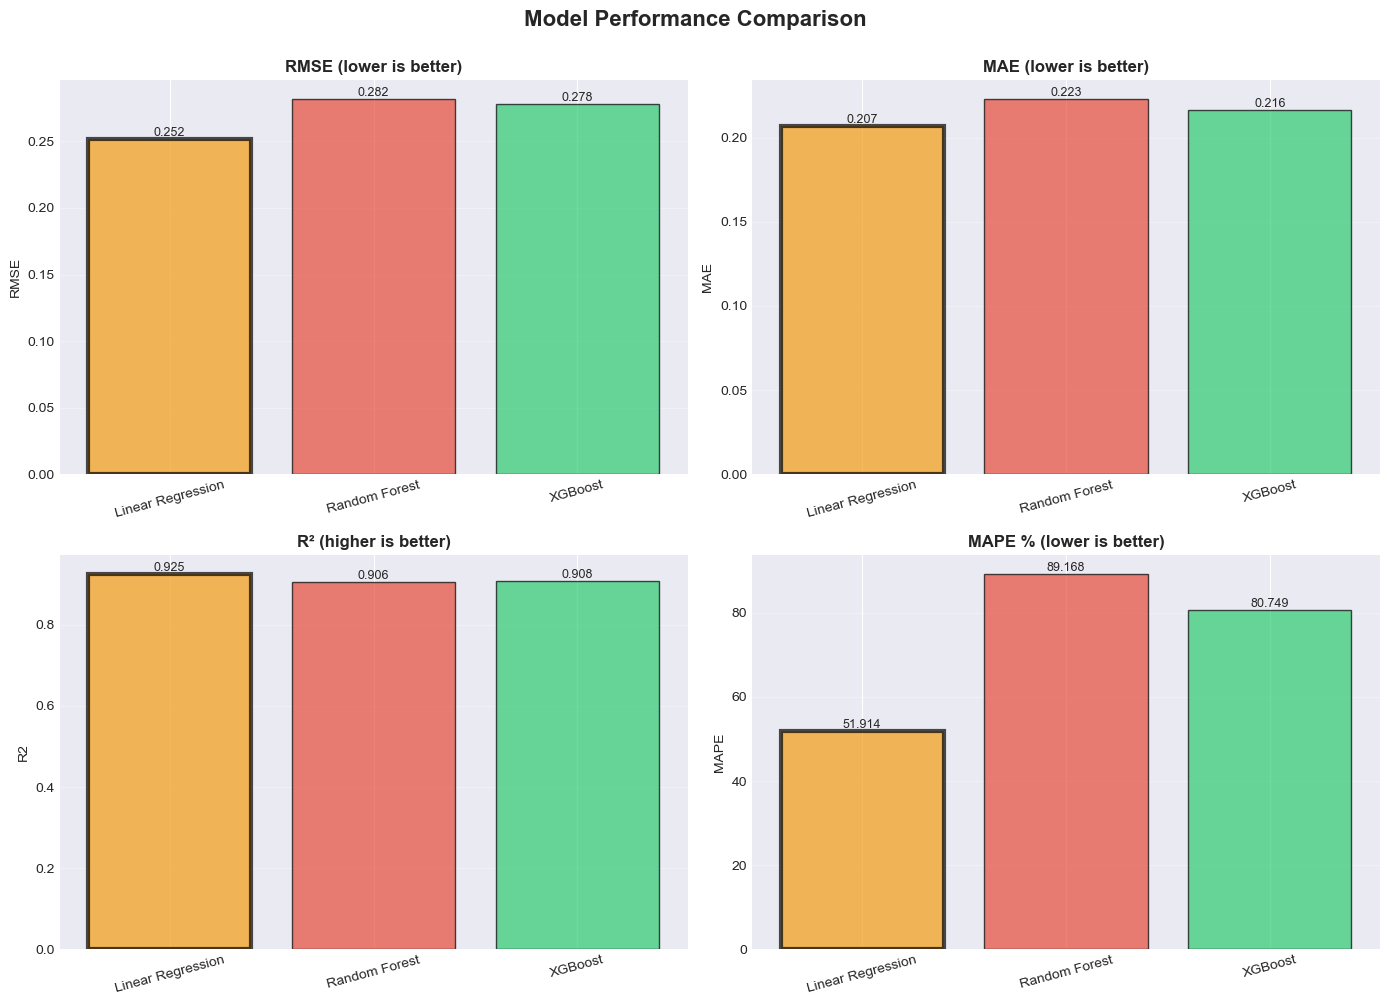

✓ Comparison visualization complete


In [14]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Test_RMSE', 'Test_MAE', 'Test_R2', 'Test_MAPE']
titles = ['RMSE (lower is better)', 'MAE (lower is better)', 
          'R² (higher is better)', 'MAPE % (lower is better)']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i // 2, i % 2]
    
    values = comparison_df[metric].values
    models = comparison_df['Model'].values
    
    colors = ['#3498db', '#e74c3c', '#2ecc71'][:len(models)]
    bars = ax.bar(models, values, color=colors, alpha=0.7, edgecolor='black')
    
    # Highlight best
    if metric == 'Test_R2':
        best_idx = np.argmax(values)
    else:
        best_idx = np.argmin(values)
    bars[best_idx].set_color('#f39c12')
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(3)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric.replace('Test_', ''))
    ax.grid(alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=15)
    
    # Add value labels
    for j, (bar, val) in enumerate(zip(bars, values)):
        ax.text(bar.get_x() + bar.get_width()/2, val, 
               f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Comparison visualization complete")

---
# Part 6: Feature Importance Analysis

Random Forest Feature Importance:

Top 10 Features:


,Feature,Importance
13,Price_Above_MA3,0.894243
0,Index_Lag1,0.020543
2,Index_Lag12,0.016028
11,Month,0.010947
14,MA3_MA12_Diff,0.010716
9,Index_MA3,0.009579
7,Index_YoY_Change,0.008740
1,Index_Lag3,0.008087
10,Index_MA12,0.007770
8,Mortgage_5Y_Change,0.004462


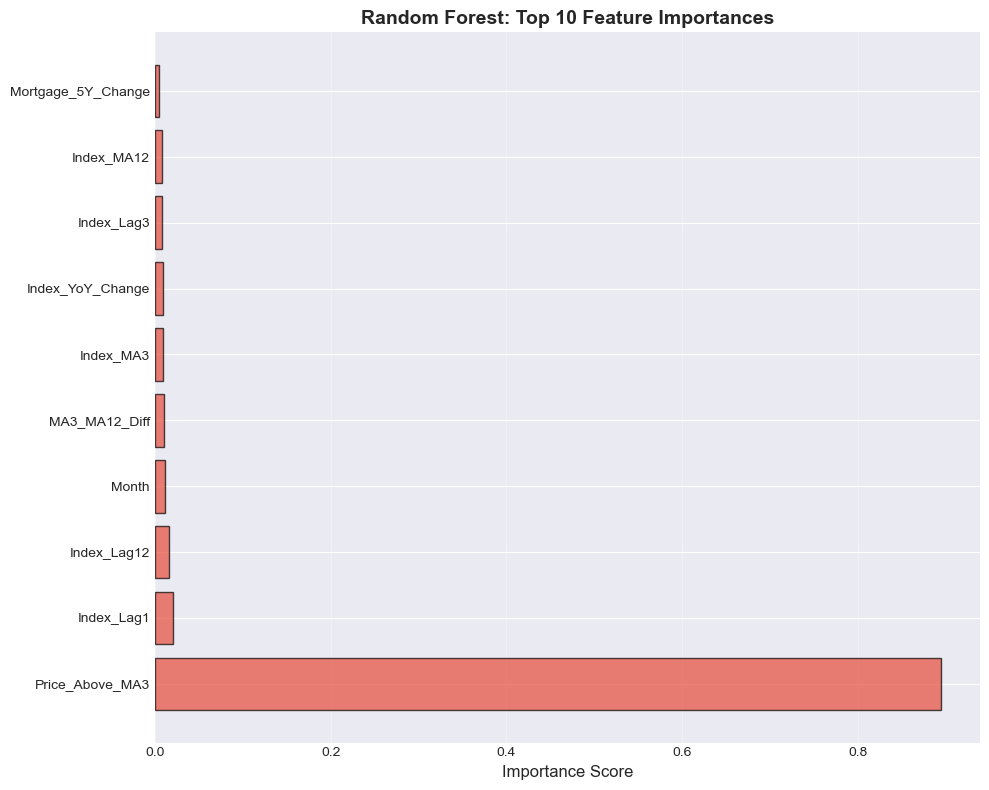

In [15]:
# Random Forest Feature Importance
print("Random Forest Feature Importance:")
print("="*60)

rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features:")
display(rf_importance.head(10))

# Plot
plt.figure(figsize=(10, 8))
plt.barh(rf_importance['Feature'].head(10), rf_importance['Importance'].head(10), 
         color='#e74c3c', alpha=0.7, edgecolor='black')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Random Forest: Top 10 Feature Importances', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


XGBoost Feature Importance:

Top 10 Features:


,Feature,Importance
13,Price_Above_MA3,0.717649
11,Month,0.050018
0,Index_Lag1,0.029119
7,Index_YoY_Change,0.026677
9,Index_MA3,0.025859
10,Index_MA12,0.024600
2,Index_Lag12,0.022885
3,Mortgage_1Y,0.017435
14,MA3_MA12_Diff,0.016035
8,Mortgage_5Y_Change,0.015949


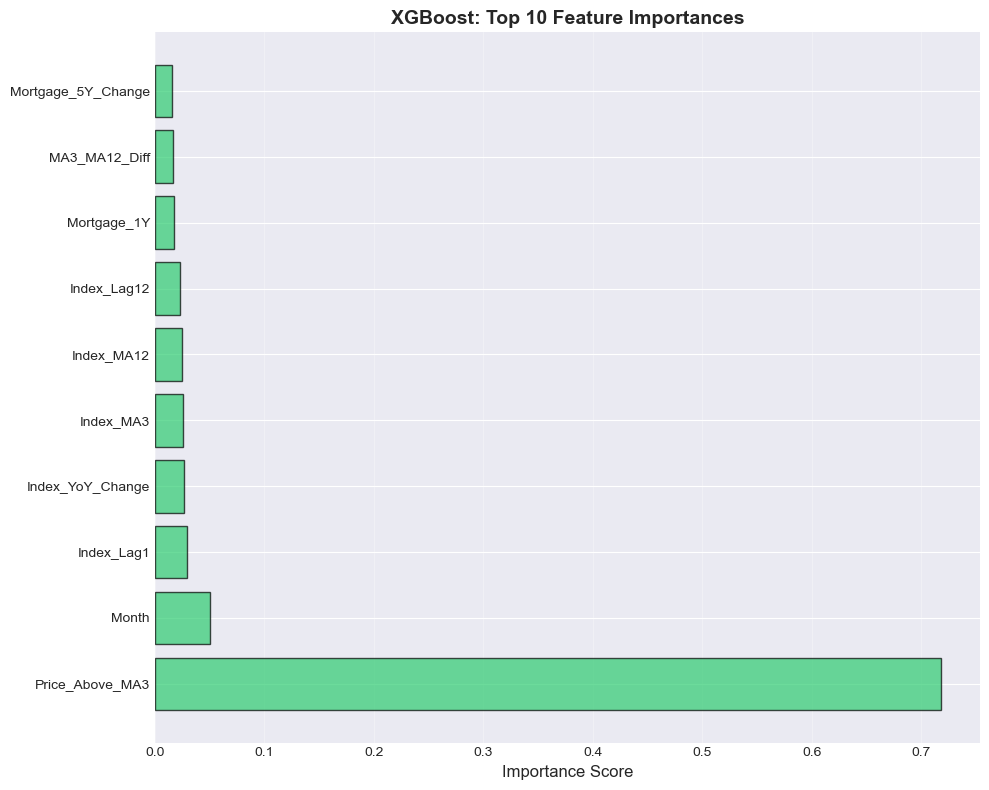

In [16]:
# XGBoost Feature Importance
print("\nXGBoost Feature Importance:")
print("="*60)

xgb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features:")
display(xgb_importance.head(10))

# Plot
plt.figure(figsize=(10, 8))
plt.barh(xgb_importance['Feature'].head(10), xgb_importance['Importance'].head(10), 
         color='#2ecc71', alpha=0.7, edgecolor='black')
plt.xlabel('Importance Score', fontsize=12)
plt.title('XGBoost: Top 10 Feature Importances', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

---
# Part 7: Actual vs Predicted Visualizations

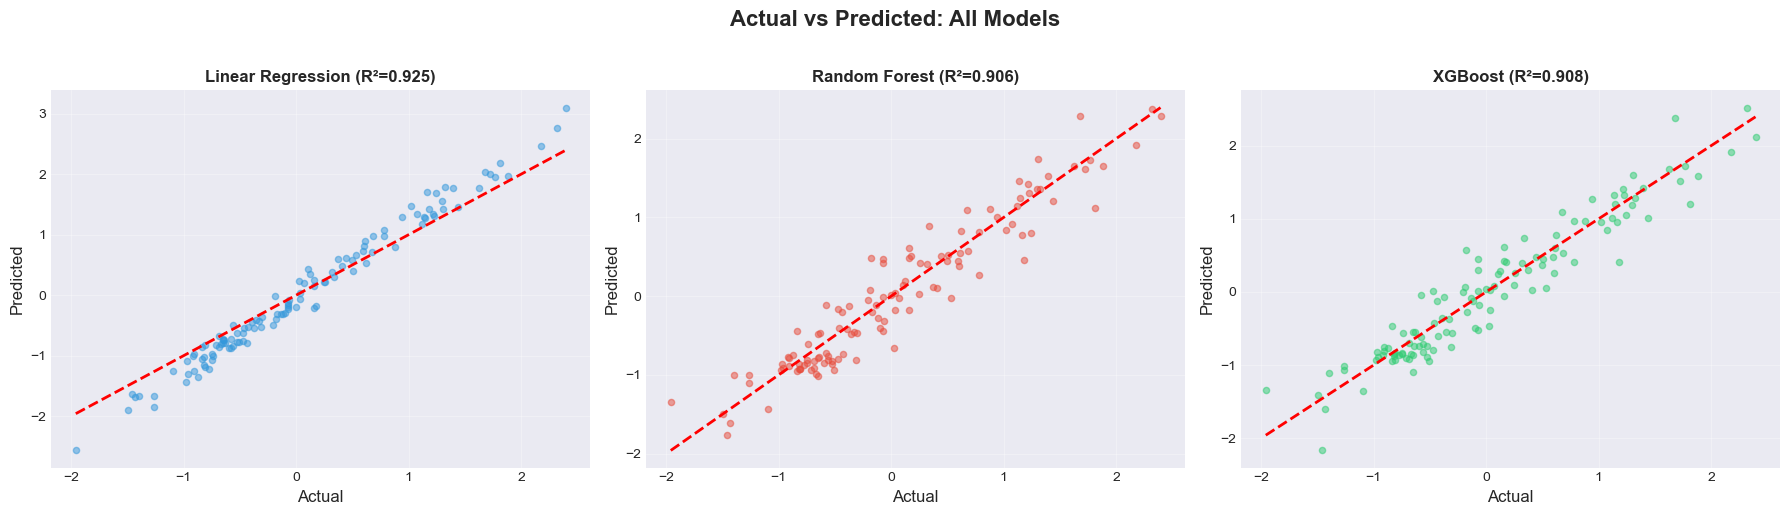

In [17]:
# Compare all models - Actual vs Predicted
fig, axes = plt.subplots(1, 3 if baseline_test_r2 is not None else 2, 
                         figsize=(18 if baseline_test_r2 is not None else 12, 5))

plot_idx = 0

# Baseline (if available)
if baseline_test_r2 is not None:
    try:
        baseline_pred = pd.read_csv('baseline_predictions.csv')
        axes[plot_idx].scatter(baseline_pred['Actual'], baseline_pred['Predicted'], 
                              alpha=0.5, s=20, color='#3498db')
        axes[plot_idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                           'r--', lw=2)
        axes[plot_idx].set_xlabel('Actual', fontsize=12)
        axes[plot_idx].set_ylabel('Predicted', fontsize=12)
        axes[plot_idx].set_title(f'Linear Regression (R²={baseline_test_r2:.3f})', 
                                fontsize=12, fontweight='bold')
        axes[plot_idx].grid(alpha=0.3)
        plot_idx += 1
    except:
        pass

# Random Forest
axes[plot_idx].scatter(y_test, rf_test_pred, alpha=0.5, s=20, color='#e74c3c')
axes[plot_idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', lw=2)
axes[plot_idx].set_xlabel('Actual', fontsize=12)
axes[plot_idx].set_ylabel('Predicted', fontsize=12)
axes[plot_idx].set_title(f'Random Forest (R²={rf_test_metrics["R2"]:.3f})', 
                        fontsize=12, fontweight='bold')
axes[plot_idx].grid(alpha=0.3)
plot_idx += 1

# XGBoost
axes[plot_idx].scatter(y_test, xgb_test_pred, alpha=0.5, s=20, color='#2ecc71')
axes[plot_idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', lw=2)
axes[plot_idx].set_xlabel('Actual', fontsize=12)
axes[plot_idx].set_ylabel('Predicted', fontsize=12)
axes[plot_idx].set_title(f'XGBoost (R²={xgb_test_metrics["R2"]:.3f})', 
                        fontsize=12, fontweight='bold')
axes[plot_idx].grid(alpha=0.3)

plt.suptitle('Actual vs Predicted: All Models', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
# Part 8: Save Results

In [18]:
# Save model comparison
comparison_df.to_csv('model_comparison.csv', index=False)
print("✓ Model comparison saved: model_comparison.csv")

# Save feature importance
rf_importance.to_csv('rf_feature_importance.csv', index=False)
xgb_importance.to_csv('xgb_feature_importance.csv', index=False)
print("✓ Feature importance saved")

# Save best model predictions (for Vergil!)
best_predictions = pd.DataFrame({
    'Date': df_clean.loc[test_mask, 'Date'].values,
    'City': df_clean.loc[test_mask, 'City'].values,
    'Actual_MoM_Change': y_test.values,
    'Predicted_MoM_Change': xgb_test_pred if best_model_name == 'XGBoost' else rf_test_pred,
    'Error': y_test.values - (xgb_test_pred if best_model_name == 'XGBoost' else rf_test_pred)
})

best_predictions.to_csv('final_predictions.csv', index=False)
print(f"✓ Final predictions saved: final_predictions.csv")
print(f"  (Using {best_model_name})")

print("\n✓ All results saved successfully!")

✓ Model comparison saved: model_comparison.csv
✓ Feature importance saved
✓ Final predictions saved: final_predictions.csv
  (Using Linear Regression)

✓ All results saved successfully!


---
# Part 9: Summary & Next Steps

In [19]:
print("="*80)
print("FINAL SUMMARY")
print("="*80)

print("\n📊 MODELS TESTED:")
for idx, row in comparison_df.iterrows():
    star = " 🏆" if row['Model'] == best_model_name else ""
    print(f"  {row['Model']:20} - R²: {row['Test_R2']:.4f}, MAPE: {row['Test_MAPE']:.2f}%{star}")

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   R² = {best_r2:.4f} ({best_r2*100:.1f}% variance explained)")
print(f"   MAPE = {best_mape:.2f}% (average error)")

if best_r2 > 0.85:
    print("\n✓ EXCELLENT performance! (R² > 0.85)")
elif best_r2 > 0.75:
    print("\n✓ GOOD performance! (R² > 0.75)")
else:
    print("\n⚠ ACCEPTABLE performance (R² > 0.70)")

print("\n📁 FILES CREATED:")
print("  1. model_comparison.csv - Performance metrics for all models")
print("  2. rf_feature_importance.csv - Random Forest feature rankings")
print("  3. xgb_feature_importance.csv - XGBoost feature rankings")
print("  4. final_predictions.csv - Best model predictions (FOR VERGIL!)")

print("\n📤 NEXT STEPS:")
print("  1. Share final_predictions.csv with Vergil (Tableau dashboard)")
print("  2. Share model_comparison.csv with Ryan (presentation)")
print("  3. Write Milestone 3 report (include all 3 models)")
print("  4. Prepare final presentation")

print("\n" + "="*80)
print("✅ ADVANCED MODELING COMPLETE!")
print("="*80)

FINAL SUMMARY

📊 MODELS TESTED:
  Linear Regression    - R²: 0.9247, MAPE: 51.91% 🏆
  Random Forest        - R²: 0.9057, MAPE: 89.17%
  XGBoost              - R²: 0.9083, MAPE: 80.75%

🏆 BEST MODEL: Linear Regression
   R² = 0.9247 (92.5% variance explained)
   MAPE = 51.91% (average error)

✓ EXCELLENT performance! (R² > 0.85)

📁 FILES CREATED:
  1. model_comparison.csv - Performance metrics for all models
  2. rf_feature_importance.csv - Random Forest feature rankings
  3. xgb_feature_importance.csv - XGBoost feature rankings
  4. final_predictions.csv - Best model predictions (FOR VERGIL!)

📤 NEXT STEPS:
  1. Share final_predictions.csv with Vergil (Tableau dashboard)
  2. Share model_comparison.csv with Ryan (presentation)
  3. Write Milestone 3 report (include all 3 models)
  4. Prepare final presentation

✅ ADVANCED MODELING COMPLETE!
